## 範例重點

學習如何在 keras 中撰寫自定義的 loss function

知道如何在訓練時使用自定義的 loss function

In [1]:
import os
import keras

# 本範例不需使用 GPU, 將 GPU 設定為 "無"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# 資料前處理 -Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [9]:
import tensorflow as tf
import keras.backend as K

"""
# 撰寫自定義的 loss function: focal loss (https://blog.csdn.net/u014380165/article/details/77019084)
"""
def focal_loss(gamma=2., alpha=4.):
    gamma = float(gamma)
    alpha = float(alpha)
    def focal_loss_fixed(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        """
        epsilon = 1e-8
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce)) # focal_loss
        reduced_fl = tf.reduce_max(fl, axis=1) # reduced focal_loss
        return tf.reduce_mean(reduced_fl)
    return focal_loss_fixed


"""
# 載入 Callbacks，撰寫一個 f1 score 的 callback function
"""

from keras.callbacks import Callback
from sklearn.metrics import f1_score

class f1sc(Callback):
    def on_train_begin(self, epoch, logs = {}):
        logs = logs or {}
        record_items = ["val_auc", "val_f1sc", "val_fp", "val_fn", "val_tp", "val_tn"]
        for i in record_items:
            if i not in self.params['metrics']:
                self.params['metrics'].append(i)
    
    def on_epoch_end(self, epoch, logs = {}, thres=0.5):
        logs = logs or {}
        y_true = self.validation_data[1].argmax(axis = 1)
        y_pred = self.model.predict(self.validation_data[0])
        y_pred = (y_pred[:, 1] >= thres) * 1
        
        logs["val_f1sc"] = f1_score(y_true = y_true, y_pred = y_pred, average="weighted")
        
log_f1sc = f1sc()

In [10]:
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()

optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
"""
# 在 compile 時，使用自定義的 loss function
"""
model.compile(loss=focal_loss(), metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[log_f1sc]
         )

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["acc"]
valid_acc = model.history.history["val_acc"]

valid_f1sc = model.history.history['val_f1sc']

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_6 (Batch (None, 128)               512       
__________

/Users/johnsonhuang/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


50000/50000 [==============================] - 6s 114us/step - loss: 4.3534 - acc: 0.4435 - val_loss: 4.8047 - val_acc: 0.4071
Epoch 3/50
50000/50000 [==============================] - 6s 123us/step - loss: 3.9385 - acc: 0.4861 - val_loss: 4.3338 - val_acc: 0.4403
Epoch 4/50
50000/50000 [==============================] - 6s 121us/step - loss: 3.6655 - acc: 0.5104 - val_loss: 4.3089 - val_acc: 0.4373
Epoch 5/50
50000/50000 [==============================] - 7s 135us/step - loss: 3.4661 - acc: 0.5340 - val_loss: 4.1028 - val_acc: 0.4557
Epoch 6/50
50000/50000 [==============================] - 6s 125us/step - loss: 3.2824 - acc: 0.5510 - val_loss: 4.1294 - val_acc: 0.4532
Epoch 7/50
50000/50000 [==============================] - 7s 139us/step - loss: 3.1174 - acc: 0.5683 - val_loss: 4.0488 - val_acc: 0.4606
Epoch 8/50
50000/50000 [==============================] - 5s 106us/step - loss: 2.9591 - acc: 0.5842 - val_loss: 4.0138 - val_acc: 0.4620
Epoch 9/50
50000/50000 [=====================

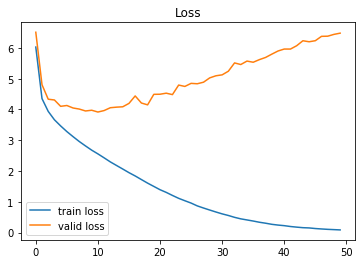

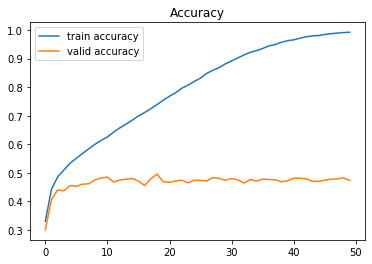

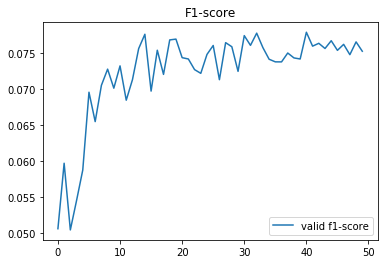

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

# plot loss
plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()
# plot acc
plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()
# plot F1-score
plt.plot(range(len(valid_f1sc)), valid_f1sc, label="valid f1-score")
plt.legend()
plt.title("F1-score")
plt.show()

## Work

請自行定義一個 loss function, 為 0.3 * focal loss + 0.7 cross-entropy，訓練並比較結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    
    """Code Here
    建立你的神經網路
    """
    
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [7]:
import tensorflow as tf
import keras.backend as K

"""Code Here
撰寫一個 loss function, 使其可以結合 focal loss 與 crossentropy loss
"""

# Define customed loss
def combined_loss(ce_weight, gamma=2., alpha=4.):
    
    gamma = float(gamma)
    alpha = float(alpha)
    
    """Define the customized loss."""
    def combined_loss_keras(y_true, y_pred):
        
        epsilon = 1e-8
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        
        ce = tf.multiply(y_true, -tf.log(model_out)) # cross entropy
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma)) # weight
        fl = tf.multiply(alpha, tf.multiply(weight, ce)) # focal_loss
        
        reduced_fl = tf.reduce_max(fl, axis=1) # reduced cross entropy
        reduced_ce = tf.reduce_max(ce, axis=1) # reduced focal_loss
        
        # 定義一個 loss function, 為 0.3 * focal loss + 0.7 cross-entropy (比例不要寫死)
        return tf.reduce_mean((1-ce_weight) * reduced_fl + (ce_weight) * reduced_ce)
    
    return combined_loss_keras


ce_weights_list = [0., 0.3, 0.5, 0.7, 1]


In [8]:
import itertools
results = {}

for i, ce_w in enumerate(ce_weights_list):
    print("Numbers of exp: %i, ce_weight: %.2f" % (i, ce_w))

    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    """Code Here
    將自定義的 loss function 加入模型
    """
    """
    # 在 compile 時，使用自定義的 loss function
    """
    # 用 combined_loss(ce_w) 因為現在迭代的代號 for i, ce_w in ...
    model.compile(loss = combined_loss(ce_w), metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True
             )
    
    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

W0726 19:22:19.173787 4346627520 deprecation_wrapper.py:119] From /Users/johnsonhuang/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0726 19:22:19.207258 4346627520 deprecation_wrapper.py:119] From /Users/johnsonhuang/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0726 19:22:19.237231 4346627520 deprecation_wrapper.py:119] From /Users/johnsonhuang/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0726 19:22:19.349383 4346627520 deprecation_wrapper.py:119] From /Users/johnsonhuang/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.p

Numbers of exp: 0, ce_weight: 0.00


W0726 19:22:19.609674 4346627520 deprecation_wrapper.py:119] From /Users/johnsonhuang/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
__________

W0726 19:22:20.031255 4346627520 deprecation.py:323] From /Users/johnsonhuang/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0726 19:22:20.545727 4346627520 deprecation_wrapper.py:119] From /Users/johnsonhuang/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 8s 156us/step - loss: 6.0843 - acc: 0.3280 - val_loss: 5.8997 - val_acc: 0.3515
Epoch 2/25
50000/50000 [==============================] - 6s 123us/step - loss: 4.4322 - acc: 0.4405 - val_loss: 4.8409 - val_acc: 0.4064
Epoch 3/25
50000/50000 [==============================] - 11s 226us/step - loss: 4.0125 - acc: 0.4801 - val_loss: 4.4203 - val_acc: 0.4348
Epoch 4/25
50000/50000 [==============================] - 9s 185us/step - loss: 3.7434 - acc: 0.5070 - val_loss: 4.2657 - val_acc: 0.4470
Epoch 5/25
50000/50000 [==============================] - 8s 153us/step - loss: 3.5327 - acc: 0.5269 - val_loss: 4.1845 - val_acc: 0.4531
Epoch 6/25
50000/50000 [==============================] - 6s 119us/step - loss: 3.3482 - acc: 0.5459 - val_loss: 4.1426 - val_acc: 0.4595
Epoch 7/25
50000/50000 [==============================] - 6s 118us/step - loss: 3.1697 - acc: 0.5626 - val_loss: 4.1141 -

50000/50000 [==============================] - 7s 136us/step - loss: 1.2200 - acc: 0.7715 - val_loss: 3.4331 - val_acc: 0.4788
Epoch 24/25
50000/50000 [==============================] - 7s 137us/step - loss: 1.1462 - acc: 0.7821 - val_loss: 3.5967 - val_acc: 0.4887
Epoch 25/25
50000/50000 [==============================] - 10s 203us/step - loss: 1.0821 - acc: 0.7947 - val_loss: 3.6693 - val_acc: 0.4799
Numbers of exp: 2, ce_weight: 0.50
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_7 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (N

Epoch 11/25
50000/50000 [==============================] - 10s 200us/step - loss: 1.7344 - acc: 0.5858 - val_loss: 2.2198 - val_acc: 0.4806
Epoch 12/25
50000/50000 [==============================] - 7s 135us/step - loss: 1.6760 - acc: 0.6012 - val_loss: 2.2128 - val_acc: 0.4845
Epoch 13/25
50000/50000 [==============================] - 7s 133us/step - loss: 1.6245 - acc: 0.6107 - val_loss: 2.2213 - val_acc: 0.4811
Epoch 14/25
50000/50000 [==============================] - 9s 185us/step - loss: 1.5743 - acc: 0.6214 - val_loss: 2.2078 - val_acc: 0.4869
Epoch 15/25
50000/50000 [==============================] - 8s 150us/step - loss: 1.5245 - acc: 0.6337 - val_loss: 2.1862 - val_acc: 0.4943
Epoch 16/25
50000/50000 [==============================] - 9s 170us/step - loss: 1.4759 - acc: 0.6438 - val_loss: 2.2201 - val_acc: 0.4903
Epoch 17/25
50000/50000 [==============================] - 8s 159us/step - loss: 1.4245 - acc: 0.6567 - val_loss: 2.2155 - val_acc: 0.4891
Epoch 18/25
50000/50000 [=

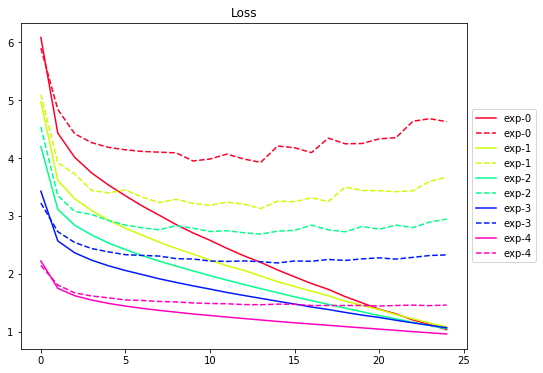

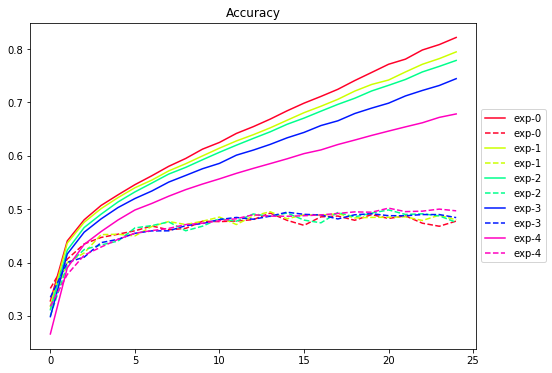

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()